# **Load Dataset and Show Random Image**

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_img(img):
    if img is not None:
        img_np = np.array(img)
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        print("No image to show.")

def show_random_image(folder_path):
    all_files = os.listdir(folder_path)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    if not image_files:
        print("No image files found in the folder.")
        return

    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(folder_path, random_image_file)

    img = mpimg.imread(random_image_path)

    show_img(img)

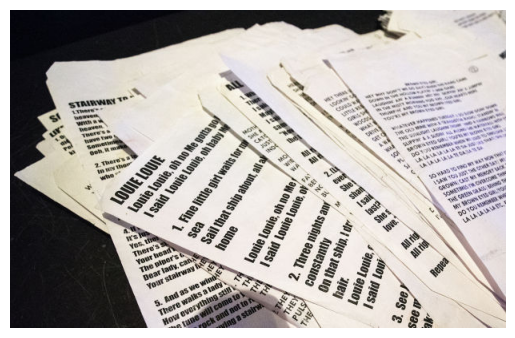

In [2]:
dataset_folder = '/kaggle/input/garbages-dataset-for-clustering/dataset_garbage'
show_random_image(dataset_folder)

# **Preprocessing Image**

In [3]:
import cv2

def read_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise ValueError(f"Error: Image at path '{img_path}' could not be read.")
    return img

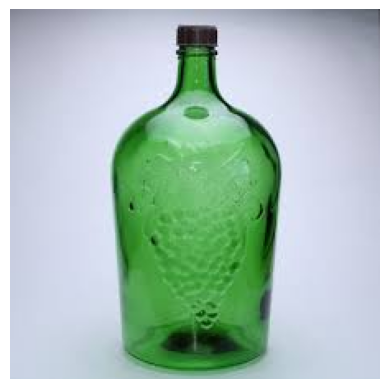

In [4]:
img_path = "/kaggle/input/garbages-dataset-for-clustering/dataset_garbage/glass_896.jpg"

img = read_image(img_path)
show_img(img)

## 1. Resize Image

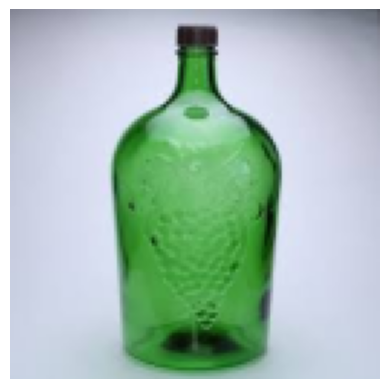

In [5]:
def resize_image(img, size=(128, 128)):
    resized_img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return resized_img

img_resized = resize_image(img)
show_img(img_resized)

## 2. Convert to Grayscale

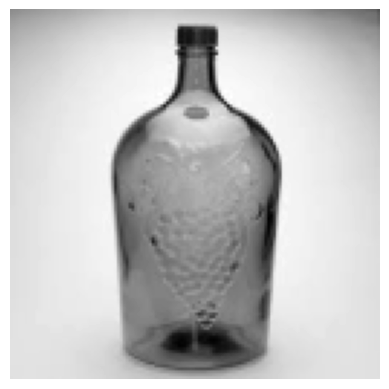

In [6]:
def convert_to_grayscale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_img

img_gray = convert_to_grayscale(img_resized)
show_img(img_gray)

## 3. Histogram Equalization

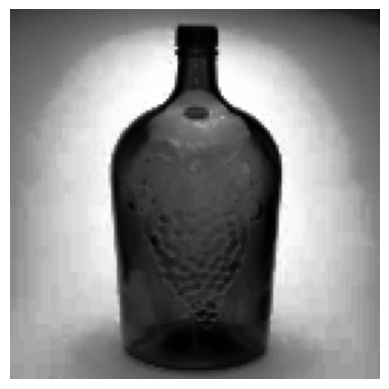

In [7]:
def histogram_equalization(img):
    if len(img.shape) == 2:
        eq_img = cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        eq_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return eq_img

img_histogram = histogram_equalization(img_gray)
show_img(img_histogram)

## 4. Normalization

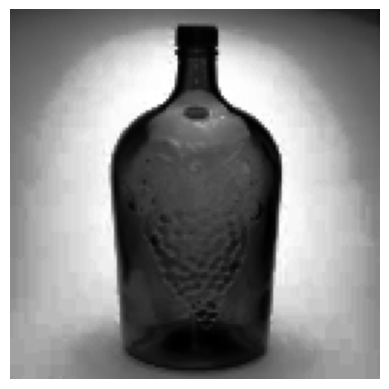

In [8]:
def normalize_image(img):
    norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_img

img_normalized = normalize_image(img_histogram)
show_img(img_normalized)

In [9]:
print("Before normalization:")
print(img_histogram)

print("\nAfter normalization:")
print(img_normalized)

Before normalization:
[[ 54  56  57 ...  20  20  14]
 [ 57  59  60 ...  27  25  18]
 [ 61  62  64 ...  28  27  20]
 ...
 [155 155 155 ... 147 147 140]
 [155 155 155 ... 147 147 140]
 [147 155 155 ... 147 147 147]]

After normalization:
[[0.21176472 0.21960786 0.22352943 ... 0.07843138 0.07843138 0.05490196]
 [0.22352943 0.23137257 0.23529413 ... 0.10588236 0.09803922 0.07058824]
 [0.2392157  0.24313727 0.2509804  ... 0.10980393 0.10588236 0.07843138]
 ...
 [0.60784316 0.60784316 0.60784316 ... 0.5764706  0.5764706  0.54901963]
 [0.60784316 0.60784316 0.60784316 ... 0.5764706  0.5764706  0.54901963]
 [0.5764706  0.60784316 0.60784316 ... 0.5764706  0.5764706  0.5764706 ]]


# **Feature Extraction**

## 1. Histogram of Oriented Gradients (HOG)

[0.08357338 0.         0.24833569 ... 0.         0.         0.        ]


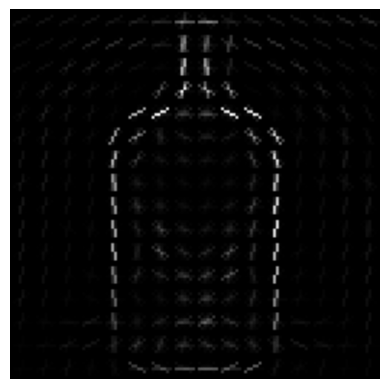

In [10]:
from skimage.feature import hog

def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    hog_result = hog(image,
                     orientations=orientations,
                     pixels_per_cell=pixels_per_cell,
                     cells_per_block=cells_per_block,
                     block_norm='L2-Hys',
                     visualize=visualize,
                     transform_sqrt=True,
                     feature_vector=True)

    if visualize:
        hog_features, hog_image = hog_result
        return hog_features, hog_image
    else:
        hog_features = hog_result
        return hog_features

hog_features, hog_image = extract_hog_features(img_normalized, visualize=True)
print(hog_features)
show_img(hog_image)

## 2. Local Binary Pattern (LBP)

[0.01544189 0.03033447 0.01501465 0.11114502 0.21118164 0.29901123
 0.05633545 0.05633545 0.15686035 0.04833984]


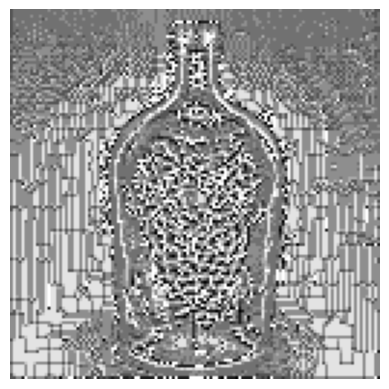

In [11]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, P=8, R=1):
    if image.dtype.kind == 'f':
        image = (image * 255).astype(np.uint8)

    lbp = local_binary_pattern(image, P, R, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))

    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return lbp, lbp_hist

lbp_image, lbp_features = extract_lbp_features(img_normalized)
print(lbp_features)
show_img(lbp_image)

## Combine Preprocessing and Feature Extraction

In [12]:
def combine_hog_and_lbp_features(hog_features, lbp_features):
    features = np.hstack((hog_features, lbp_features))
    return features

In [13]:
def preprocess_and_extract_features(img_path):
    img = read_image(img_path)

    # Preprocessing
    img_resized = resize_image(img)
    img_gray = convert_to_grayscale(img_resized)
    img_histogram = histogram_equalization(img_gray)
    img_normalized = normalize_image(img_histogram)

    # Feature Extraction
    hog_features = extract_hog_features(img_normalized, visualize=False)
    _, lbp_features = extract_lbp_features(img_normalized)

    # Combining HOG and LBP Features
    features = combine_hog_and_lbp_features(hog_features, lbp_features)
    return features

In [14]:
img_path = "/kaggle/input/garbages-dataset-for-clustering/dataset_garbage/glass_896.jpg"

features = preprocess_and_extract_features(img_path)
features

array([0.08357338, 0.        , 0.24833569, ..., 0.05633545, 0.15686035,
       0.04833984])

# **Preprocessing All Images**

In [15]:
from tqdm import tqdm

image_folder = '/kaggle/input/garbages-dataset-for-clustering/dataset_garbage'

all_features = []
image_paths = []

image_files = [filename for filename in os.listdir(image_folder) if filename.endswith('.jpg') or filename.endswith('.png')]
total_files = len(image_files)

for filename in tqdm(image_files, total=total_files, desc="Processing Images"):
    img_path = os.path.join(image_folder, filename)
    try:
        features = preprocess_and_extract_features(img_path)
        all_features.append(features)
        image_paths.append(img_path)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

Processing Images:  70%|███████   | 16642/23642 [07:52<03:09, 36.96it/s]

Error processing /kaggle/input/garbages-dataset-for-clustering/dataset_garbage/plastic_154.jpg: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Processing Images: 100%|██████████| 23642/23642 [11:11<00:00, 35.19it/s]


## Dimension Reduction

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features)

# **Clustering with K-Means**

In [18]:
from sklearn.cluster import KMeans

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42, max_iter=1000)
kmeans.fit(features_2d)

kmeans_labels = kmeans.labels_

print(kmeans_labels)

[7 2 3 ... 2 4 3]


## Evaluation Metrics

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tabulate import tabulate

# Silhouette Score
silhouette_avg = silhouette_score(features_2d, kmeans_labels)
# Davies-Bouldin Index
db_score = davies_bouldin_score(features_2d, kmeans_labels)
# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(features_2d, kmeans_labels)

results = [
    ["Silhouette Score", silhouette_avg],
    ["Davies-Bouldin Index", db_score],
    ["Calinski-Harabasz Index", ch_score]
]

print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid", stralign="left", floatfmt=".4f"))

+-------------------------+------------+
| Metric                  |      Value |
+=========================+============+
| Silhouette Score        |     0.3344 |
+-------------------------+------------+
| Davies-Bouldin Index    |     0.8532 |
+-------------------------+------------+
| Calinski-Harabasz Index | 20452.4595 |
+-------------------------+------------+


## Counts Number of Images from Each Cluster

In [20]:
from tabulate import tabulate
import numpy as np

cluster_counts = np.bincount(kmeans_labels)

table_data = []
for i, count in enumerate(cluster_counts):
    table_data.append([f"Cluster {i}", count])

print(tabulate(table_data, headers=["Cluster", "Number of Images"], tablefmt="pretty"))


+-----------+------------------+
|  Cluster  | Number of Images |
+-----------+------------------+
| Cluster 0 |       1313       |
| Cluster 1 |       2746       |
| Cluster 2 |       2964       |
| Cluster 3 |       1401       |
| Cluster 4 |       3885       |
| Cluster 5 |       3939       |
| Cluster 6 |       1771       |
| Cluster 7 |       2741       |
| Cluster 8 |       1595       |
| Cluster 9 |       1286       |
+-----------+------------------+


## Visualize with Scatter Plot

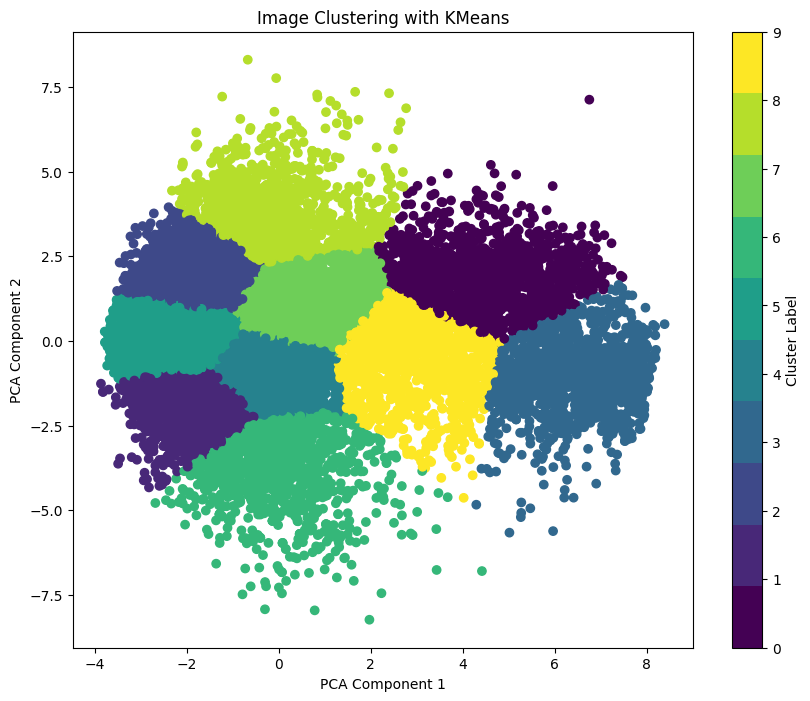

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

unique_labels = np.unique(kmeans_labels)
num_labels = len(unique_labels)

viridis = plt.get_cmap('viridis', num_labels)
colors = viridis(np.arange(num_labels))
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=kmeans_labels, cmap=cmap)
cbar = plt.colorbar(scatter, ticks=unique_labels)
cbar.set_label('Cluster Label')
plt.title('Image Clustering with KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Displays 5 Images from Each Cluster

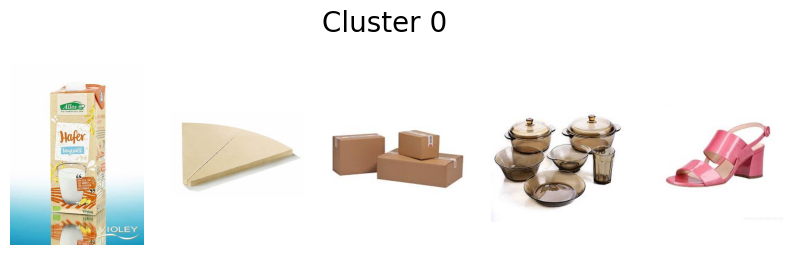

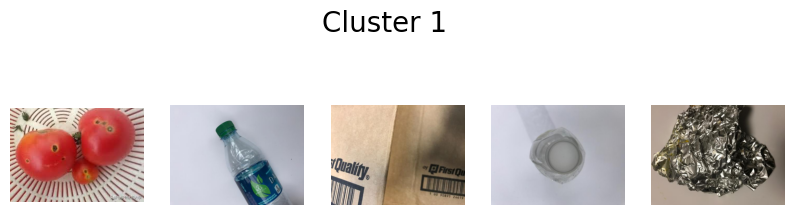

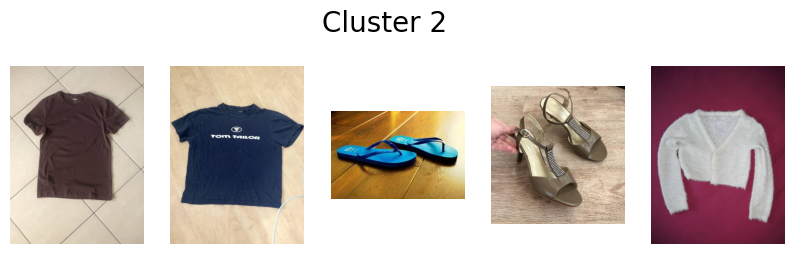

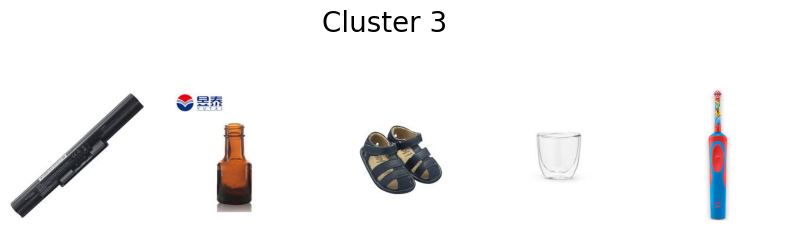

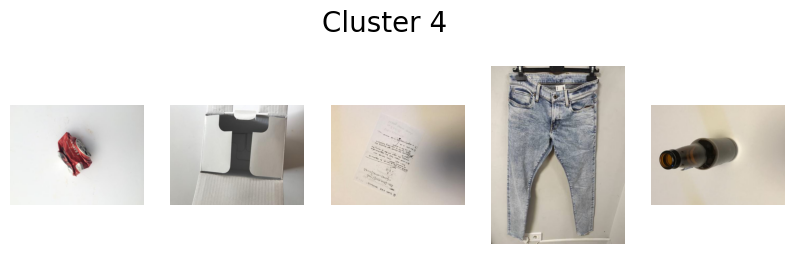

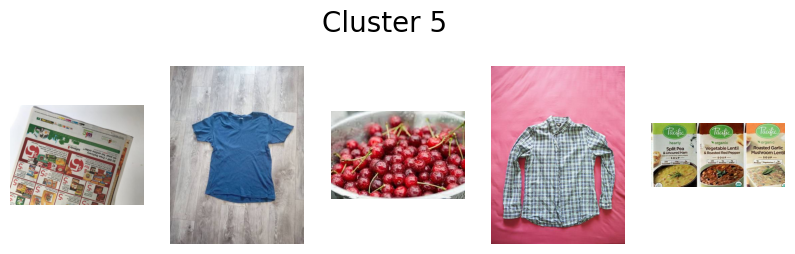

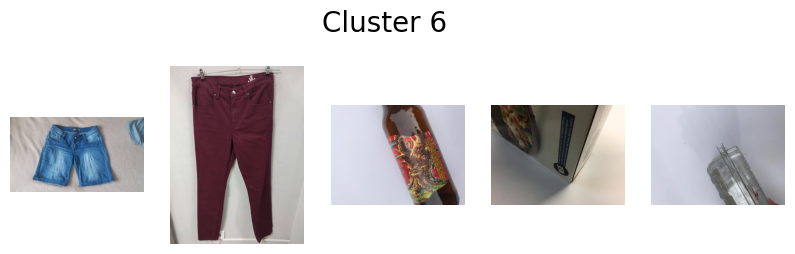

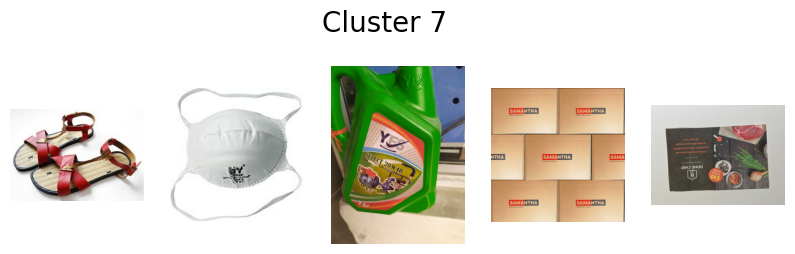

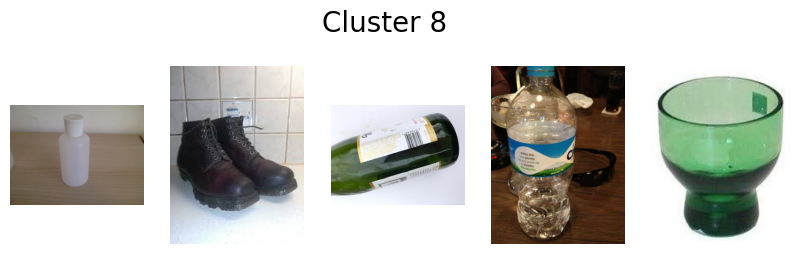

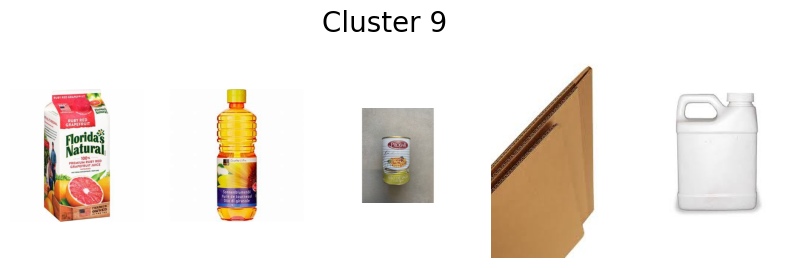

In [22]:
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    cluster_images = [image_paths[i] for i in cluster_indices[:5]]

    plt.figure(figsize=(10, 3))
    plt.suptitle(f'Cluster {cluster}', size=20)

    for i, img_path in enumerate(cluster_images):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')

    plt.show()

# **Clustering with SOM**

In [23]:
!pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=a0f32b88f70193fabe03b4b482b7422faba8a58924f3bd9c47564d942dcb6a3d
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built MiniSom


In [24]:
import numpy as np
from minisom import MiniSom
import cv2

som_dim = (10, 1) # 10 clusters
som = MiniSom(som_dim[0], som_dim[1], features_2d.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
som.random_weights_init(features_2d)
som.train_random(features_2d, 1000)

som_labels = np.array([som.winner(x)[0] for x in features_2d])
som_labels

array([1, 9, 6, ..., 9, 0, 6])

## Evaluation Metrics

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tabulate import tabulate

# Silhouette Score
silhouette_avg = silhouette_score(features_2d, som_labels)
# Davies-Bouldin Index
db_score = davies_bouldin_score(features_2d, som_labels)
# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(features_2d, som_labels)

results = [
    ["Silhouette Score", silhouette_avg],
    ["Davies-Bouldin Index", db_score],
    ["Calinski-Harabasz Index", ch_score]
]

print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid", stralign="left", floatfmt=".4f"))

+-------------------------+------------+
| Metric                  |      Value |
+=========================+============+
| Silhouette Score        |     0.3084 |
+-------------------------+------------+
| Davies-Bouldin Index    |     0.9727 |
+-------------------------+------------+
| Calinski-Harabasz Index | 17958.1381 |
+-------------------------+------------+


## Counts Number of Images from Each Cluster

In [26]:
from tabulate import tabulate
import numpy as np

cluster_counts = np.bincount(som_labels)

table_data = []
for i, count in enumerate(cluster_counts):
    table_data.append([f"Cluster {i}", count])

print(tabulate(table_data, headers=["Cluster", "Number of Images"], tablefmt="pretty"))


+-----------+------------------+
|  Cluster  | Number of Images |
+-----------+------------------+
| Cluster 0 |       4192       |
| Cluster 1 |       3846       |
| Cluster 2 |       2030       |
| Cluster 3 |       3731       |
| Cluster 4 |       1633       |
| Cluster 5 |       560        |
| Cluster 6 |       1679       |
| Cluster 7 |       1655       |
| Cluster 8 |       1210       |
| Cluster 9 |       3105       |
+-----------+------------------+


## Visualize with Scatter Plot

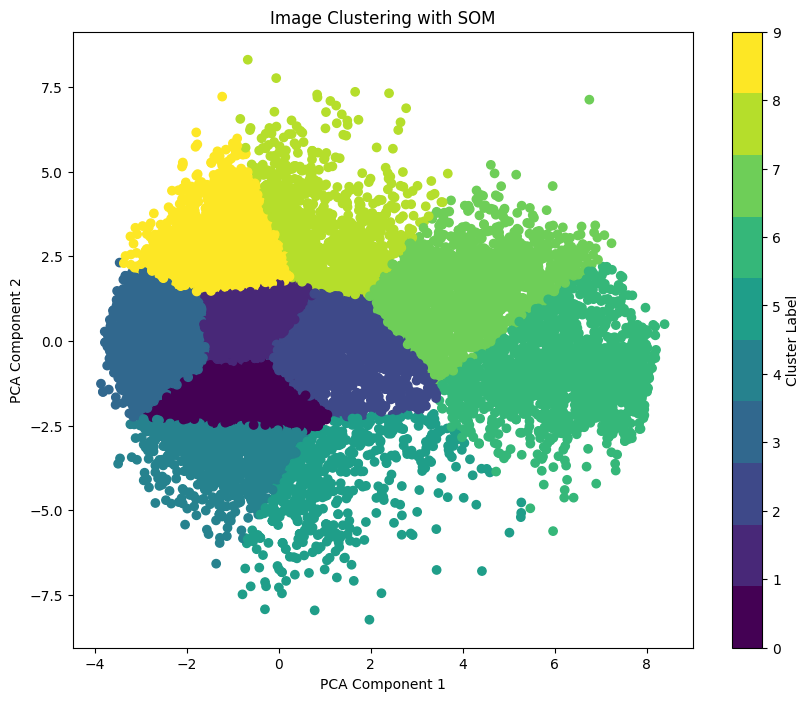

In [27]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

unique_labels = np.unique(som_labels)
num_labels = len(unique_labels)

viridis = plt.get_cmap('viridis', num_labels)
colors = viridis(np.arange(num_labels))
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=som_labels, cmap=cmap)
cbar = plt.colorbar(scatter, ticks=unique_labels)
cbar.set_label('Cluster Label')
plt.title('Image Clustering with SOM')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Displays 5 Images from Each Cluster

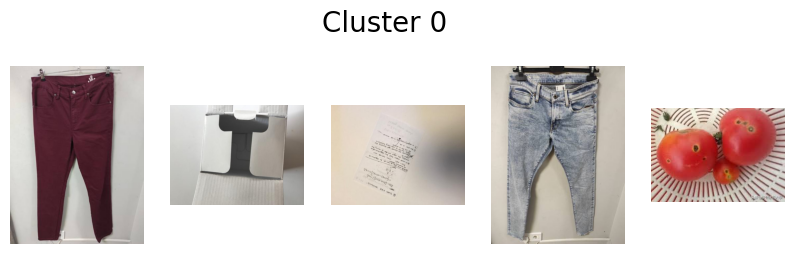

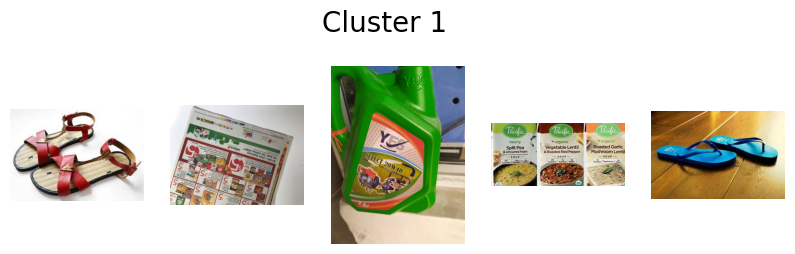

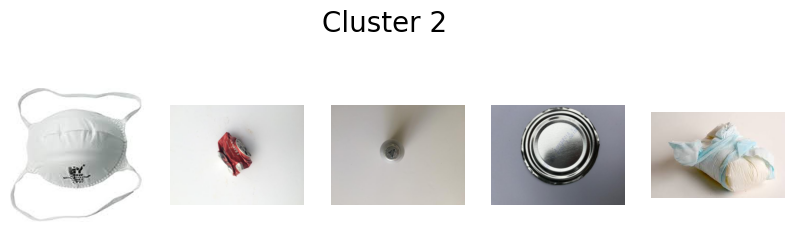

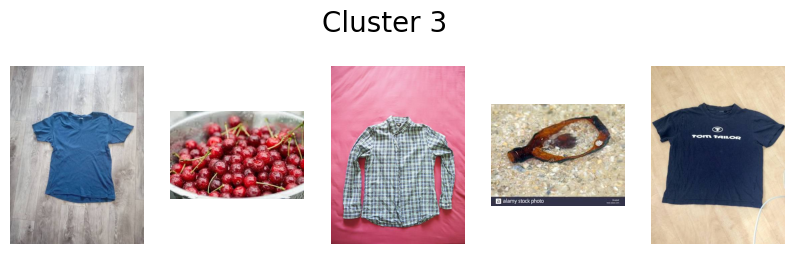

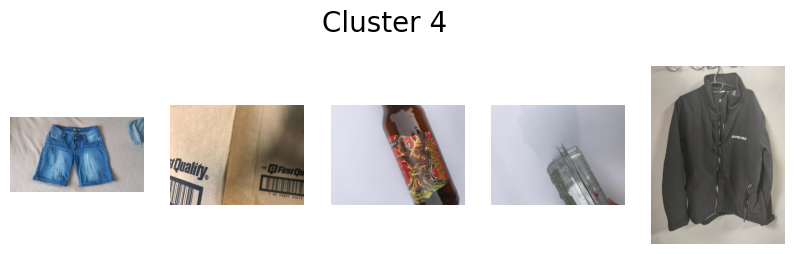

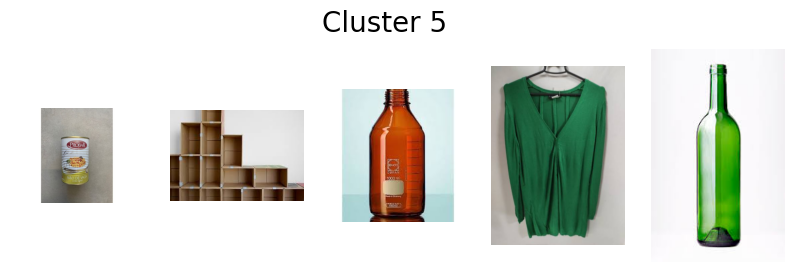

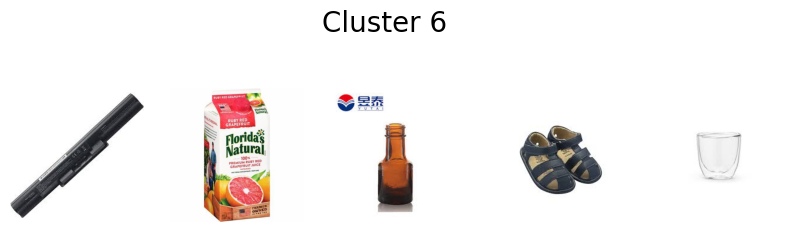

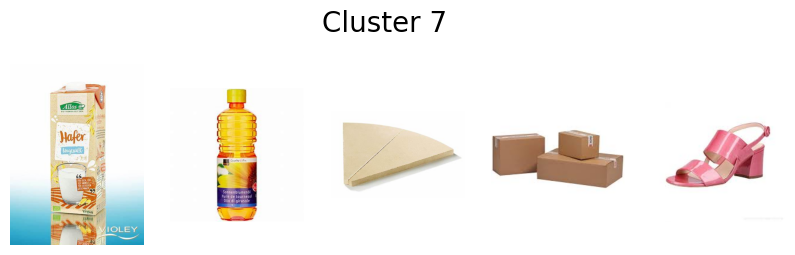

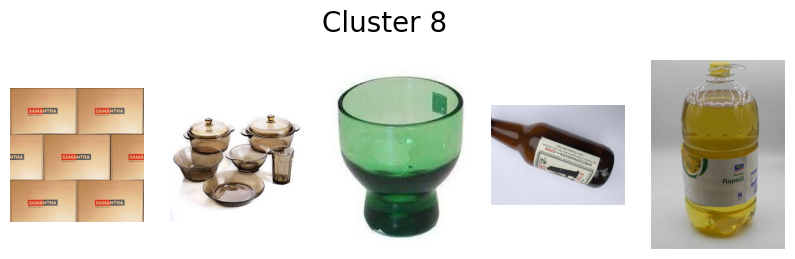

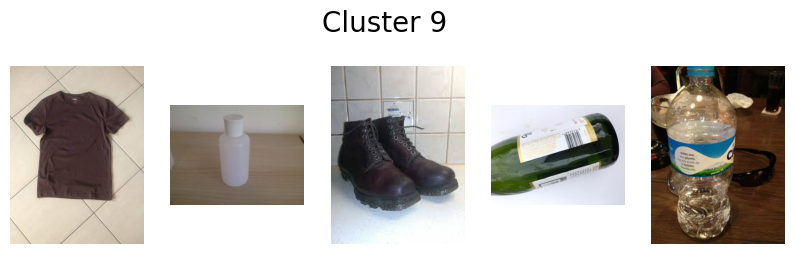

In [28]:
for cluster in range(num_clusters):
    cluster_indices = np.where(som_labels == cluster)[0]
    cluster_images = [image_paths[i] for i in cluster_indices[:5]]

    plt.figure(figsize=(10, 3))
    plt.suptitle(f'Cluster {cluster}', size=20)

    for i, img_path in enumerate(cluster_images):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')

    plt.show()